In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from functools import partial
from scipy import stats as st
from typing import Tuple, List
from matplotlib import pyplot as plt

from tklds.interface.integrals import get_integral_by_name
from tklds.interface.integrals import get_sequence_enum
from tklds.interface.integrals import get_effective_dimension_enum
from tklds.interface.integrals import get_integral_effective_dimension_function
from tklds.interface.generators import create_iterative_lds_generator
from tklds.integrals.effective_dimensions import mean_effective_dimension_single
from tklds.integrals.effective_dimensions import mean_effective_dimension_lst

In [2]:
NUM_DIM = 50
DIMENSIONS = np.arange(1, NUM_DIM, 1)

NUM_POINTS = [2 ** i for i in range(5, 15)]
NUM_POINTS = NUM_POINTS + list([int(i) for i in np.logspace(5, 15, 30, base=2, dtype=int)])
NUM_POINTS = np.sort(np.unique(NUM_POINTS))

SKIP = 0

In [3]:
function = get_integral_by_name('lds_investigations_f1_comparison')
g_function = lambda x, d=1: function(x, NUM_DIM)

equation_text = "$I = \\frac{12}{d} \int_{[0,1]^d} \sum_{j=1}^{d} \\left( x_j - \\frac{1}{2} \\right) dx_j$"

In [4]:
results = pd.DataFrame(columns=["generator", "num_samples", "expected_result", "actual_result"])
for generator_sequence in get_sequence_enum():
    num_samples, actual, expected = [], [], []
    generator = st.uniform(0, 1) if generator_sequence.value == 'pcg64' else create_iterative_lds_generator(generator_sequence, NUM_DIM)
    
    for n in tqdm(NUM_POINTS):
        u = generator.rvs(size=(int(n) + SKIP, NUM_DIM))[SKIP:]
        expected_result, actual_result = function(u)
        num_samples.append(n)
        expected.append(expected_result)
        actual.append(actual_result)

    sub_results_dict = {"num_samples": num_samples, "expected_result": expected, "actual_result": actual}
    sub_results = pd.DataFrame(sub_results_dict)
    sub_results["generator"] = generator_sequence.value
    results = pd.concat([results, sub_results])
    

100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 189.03it/s]


In [5]:
mean_dimension = get_effective_dimension_enum().ADDITIVE_SUPERPOSITION
mean_eff_dim = mean_effective_dimension_single(g_function, mean_dimension, DIMENSIONS)

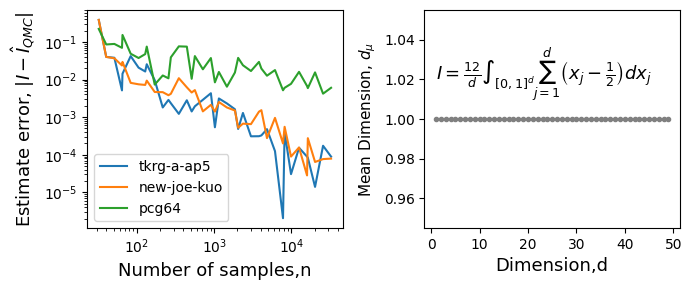

In [6]:
sf, fs = 1.0, 13
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(sf * 7, sf * 3))

sequence_name_lst = [generator_sequence.value for generator_sequence in get_sequence_enum()]

COLORS = {
    sequence_name_lst[0]: "C0",
    sequence_name_lst[1]: "C1",
    sequence_name_lst[2]: "C2"
}

y_label = "Estimate error, $|I - \\hat{I}_{QMC}|$"
for sequence_name in sequence_name_lst:
    subset = results[results["generator"] == sequence_name]
    num_samples = subset["num_samples"]
    c = COLORS[sequence_name]
    alpha = 1.0 if c != "C2" else 1
    values = np.abs(subset["expected_result"] - subset["actual_result"])
    ax1.loglog(num_samples, values, label=sequence_name, color=c, alpha=alpha)
    
ax1.set_xlabel("Number of samples,n", fontsize=fs)
ax1.set_ylabel(y_label, fontsize=fs)
ax1.legend()

ax2.plot(DIMENSIONS, mean_eff_dim, ".-", color="gray")
ax2.set_xlabel("Dimension,d", fontsize=fs)
ax2.set_ylabel("Mean Dimension, $d_{\\mu}$", fontsize=fs - 2)
ax2.text(np.min(DIMENSIONS), 1.02, equation_text, fontsize=fs)

ax1.legend()

plt.tight_layout()

In [7]:
function = get_integral_by_name('roos_and_arnold_3_comparison')
g_function = lambda x, j: get_integral_by_name('roos_and_arnold_3')(x)

equation_text = "$I = \int_{[0,1]^d} \prod_{j=1}^{d} \\left( \\frac{\\pi}{2}\\sin(\\pi x_j) \\right) dx_j$"

In [8]:
results = pd.DataFrame(columns=["generator", "num_samples", "expected_result", "actual_result"])
for generator_sequence in get_sequence_enum():
    num_samples, actual, expected = [], [], []
    generator = st.uniform(0, 1) if generator_sequence.value == 'pcg64' else create_iterative_lds_generator(generator_sequence, NUM_DIM)
    
    for n in tqdm(NUM_POINTS):
        u = generator.rvs(size=(int(n) + SKIP, NUM_DIM))[SKIP:]
        expected_result, actual_result = function(u)
        num_samples.append(n)
        expected.append(expected_result)
        actual.append(actual_result)

    sub_results_dict = {"num_samples": num_samples, "expected_result": expected, "actual_result": actual}
    sub_results = pd.DataFrame(sub_results_dict)
    sub_results["generator"] = generator_sequence.value
    results = pd.concat([results, sub_results])
  

100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 108.17it/s]


In [9]:
def make_g_lst(d):
    return [partial(g_function, j=sub_d) for sub_d in range(1, d + 1)]

mean_dimension = get_effective_dimension_enum().MULTIPLICATIVE_SUPERPOSITION
mean_eff_dim = mean_effective_dimension_lst(make_g_lst, mean_dimension, DIMENSIONS)

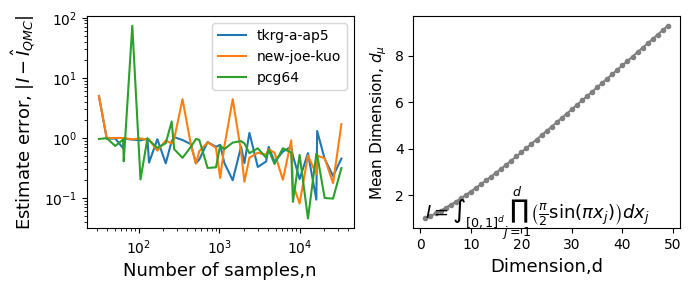

In [10]:
sf, fs = 1.0, 13
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(sf * 7, sf * 3))

sequence_name_lst = [generator_sequence.value for generator_sequence in get_sequence_enum()]

COLORS = {
    sequence_name_lst[0]: "C0",
    sequence_name_lst[1]: "C1",
    sequence_name_lst[2]: "C2"
}

y_label = "Estimate error, $|I - \\hat{I}_{QMC}|$"
for sequence_name in sequence_name_lst:
    subset = results[results["generator"] == sequence_name]
    num_samples = subset["num_samples"]
    c = COLORS[sequence_name]
    alpha = 1.0 if c != "C2" else 1
    values = np.abs(subset["expected_result"] - subset["actual_result"])
    ax1.loglog(num_samples, values, label=sequence_name, color=c, alpha=alpha)
    
ax1.set_xlabel("Number of samples,n", fontsize=fs)
ax1.set_ylabel(y_label, fontsize=fs)
ax1.legend()

ax2.plot(DIMENSIONS, mean_eff_dim, ".-", color="gray")
ax2.set_xlabel("Dimension,d", fontsize=fs)
ax2.set_ylabel("Mean Dimension, $d_{\\mu}$", fontsize=fs - 2)
ax2.text(np.min(DIMENSIONS), 1.02, equation_text, fontsize=fs)

ax1.legend()

plt.tight_layout()